# Step 3: Quantile Delta Mapping with reimplemented cmethods tools
Apply reimplemented QDM functionality to additional example cases: longer time series, full grid around Greenland, and sectoral average TF.

23 Jan 2025 | EHU

Edits:
- 23 Jan: Loading in 1950-1999 rather than 2000-2014. Give us a longer series to play with and see how QDM performs
- 24 Jan: Use `rioxarray` to match the EN4 grid to CESM, and then apply our QDM function to the full grid.
- 30 Jan: Clean up unused code.  Read in series from a multifile dataset to stitch together 1950-2014 series
- 31 Jan: QDM-correct annual series rather than monthly.  Add monthly variability residual back after correction.

In [1]:
import os
import sys
import copy
import csv
import time
import datetime
import math
import cartopy.crs as ccrs ## map projections
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt

import rioxarray
from pyproj import CRS

## Re-implement functions from Cmethods

In [2]:
## from cmethods.utils
import warnings
from typing import TYPE_CHECKING, Optional, Union, TypeVar

XRData_t = (xr.Dataset, xr.DataArray)
NPData_t = (list, np.ndarray, np.generic)
XRData = TypeVar("XRData", xr.Dataset, xr.DataArray)
NPData = TypeVar("NPData", list, np.ndarray, np.generic)


def check_xr_types(obs: XRData, simh: XRData, simp: XRData) -> None:
    """
    Checks if the parameters are in the correct type. **only used internally**
    """
    phrase: str = "must be type xarray.core.dataarray.Dataset or xarray.core.dataarray.DataArray"

    if not isinstance(obs, XRData_t):
        raise TypeError(f"'obs' {phrase}")
    if not isinstance(simh, XRData_t):
        raise TypeError(f"'simh' {phrase}")
    if not isinstance(simp, XRData_t):
        raise TypeError(f"'simp' {phrase}")

def check_np_types(
    obs: NPData,
    simh: NPData,
    simp: NPData,
) -> None:
    """
    Checks if the parameters are in the correct type. **only used internally**
    """
    phrase: str = "must be type list, np.ndarray or np.generic"

    if not isinstance(obs, NPData_t):
        raise TypeError(f"'obs' {phrase}")
    if not isinstance(simh, NPData_t):
        raise TypeError(f"'simh' {phrase}")
    if not isinstance(simp, NPData_t):
        raise TypeError(f"'simp' {phrase}")

def nan_or_equal(value1: float, value2: float) -> bool:
    """
    Returns True if the values are equal or at least one is NaN

    :param value1: First value to check
    :type value1: float
    :param value2: Second value to check
    :type value2: float
    :return: If any value is NaN or values are equal
    :rtype: bool
    """
    return np.isnan(value1) or np.isnan(value2) or value1 == value2
        
def ensure_dividable(
    numerator: Union[float, np.ndarray],
    denominator: Union[float, np.ndarray],
    max_scaling_factor: float,
) -> np.ndarray:
    """
    Ensures that the arrays can be divided. The numerator will be multiplied by
    the maximum scaling factor of the CMethods class if division by zero.

    :param numerator: Numerator to use
    :type numerator: np.ndarray
    :param denominator: Denominator that can be zero
    :type denominator: np.ndarray
    :return: Zero-ensured division
    :rtype: np.ndarray | float
    """
    with np.errstate(divide="ignore", invalid="ignore"):
        result = numerator / denominator

    if isinstance(numerator, np.ndarray):
        mask_inf = np.isinf(result)
        result[mask_inf] = numerator[mask_inf] * max_scaling_factor  # type: ignore[index]

        mask_nan = np.isnan(result)
        result[mask_nan] = 0  # type: ignore[index]
    elif np.isinf(result):
        result = numerator * max_scaling_factor
    elif np.isnan(result):
        result = 0.0

    return result

def get_pdf(
    x: Union[list, np.ndarray],
    xbins: Union[list, np.ndarray],
) -> np.ndarray:
    r"""
    Compuites and returns the the probability density function :math:`P(x)`
    of ``x`` based on ``xbins``.

    :param x: The vector to get :math:`P(x)` from
    :type x: list | np.ndarray
    :param xbins: The boundaries/bins of :math:`P(x)`
    :type xbins: list | np.ndarray
    :return: The probability densitiy function of ``x``
    :rtype: np.ndarray

    .. code-block:: python
        :linenos:
        :caption: Compute the probability density function :math:`P(x)`

        >>> from cmethods get_pdf

        >>> x = [1, 2, 3, 4, 5, 5, 5, 6, 7, 8, 9, 10]
        >>> xbins = [0, 3, 6, 10]
        >>> print(get_pdf(x=x, xbins=xbins))
        [2, 5, 5]
    """
    pdf, _ = np.histogram(x, xbins)
    return pdf


def get_cdf(
    x: Union[list, np.ndarray],
    xbins: Union[list, np.ndarray],
) -> np.ndarray:
    r"""
    Computes and returns returns the cumulative distribution function :math:`F(x)`
    of ``x`` based on ``xbins``.

    :param x: Vector to get :math:`F(x)` from
    :type x: list | np.ndarray
    :param xbins: The boundaries/bins of :math:`F(x)`
    :type xbins: list | np.ndarray
    :return: The cumulative distribution function of ``x``
    :rtype: np.ndarray


    .. code-block:: python
        :linenos:
        :caption: Compute the cumulative distribution function :math:`F(x)`

        >>> from cmethods.utils import get_cdf

        >>> x = [1, 2, 3, 4, 5, 5, 5, 6, 7, 8, 9, 10]
        >>> xbins = [0, 3, 6, 10]
        >>> print(get_cdf(x=x, xbins=xbins))
        [0.0, 0.16666667, 0.58333333, 1.]
    """
    pdf, _ = np.histogram(x, xbins)
    cdf = np.insert(np.cumsum(pdf), 0, 0.0)
    return cdf / cdf[-1]


def get_inverse_of_cdf(
    base_cdf: Union[list, np.ndarray],
    insert_cdf: Union[list, np.ndarray],
    xbins: Union[list, np.ndarray],
) -> np.ndarray:
    r"""
    Returns the inverse cumulative distribution function as:
    :math:`F^{-1}_{x}\left[y\right]` where :math:`x` represents ``base_cdf`` and
    ``insert_cdf`` is represented by :math:`y`.

    :param base_cdf: The basis
    :type base_cdf: list | np.ndarray
    :param insert_cdf: The CDF that gets inserted
    :type insert_cdf: list | np.ndarray
    :param xbins: Probability boundaries
    :type xbins: list | np.ndarray
    :return: The inverse CDF
    :rtype: np.ndarray
    """
    return np.interp(insert_cdf, base_cdf, xbins)


In [3]:
def quantile_delta_mapping(
    obs: NPData,
    simh: NPData,
    simp: NPData,
    n_quantiles: int,
    kind: str = "+",
    **kwargs,
    ) -> NPData:
    r"""
    Based on https://python-cmethods.readthedocs.io/en/latest/methods.html#quantile-delta-mapping

    kind: str, default + for additive, can be set to * for multiplicative
    """
    # check_adjust_called(
    #     function_name="quantile_delta_mapping",
    #     adjust_called=kwargs.get("adjust_called"),
    # )
    check_np_types(obs=obs, simh=simh, simp=simp)

    if not isinstance(n_quantiles, int):
        raise TypeError("'n_quantiles' must be type int")

    if kind=='+':
        obs, simh, simp = (
            np.array(obs),
            np.array(simh),
            np.array(simp),
        )  # to achieve higher accuracy
        global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
        global_min = kwargs.get("global_min", min(np.nanmin(obs), np.nanmin(simh)))

        if nan_or_equal(value1=global_max, value2=global_min):
            return simp

        wide = abs(global_max - global_min) / n_quantiles
        xbins = np.arange(global_min, global_max + wide, wide)

        cdf_obs = get_cdf(obs, xbins)
        cdf_simh = get_cdf(simh, xbins)
        cdf_simp = get_cdf(simp, xbins)

        # calculate exact CDF values of $F_{sim,p}[T_{sim,p}(t)]$
        epsilon = np.interp(simp, xbins, cdf_simp)  # Eq. 1.1
        QDM1 = get_inverse_of_cdf(cdf_obs, epsilon, xbins)  # Eq. 1.2
        delta = simp - get_inverse_of_cdf(cdf_simh, epsilon, xbins)  # Eq. 1.3
        return QDM1 + delta  # Eq. 1.4

    if kind=='*':
        obs, simh, simp = np.array(obs), np.array(simh), np.array(simp)
        global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
        global_min = kwargs.get("global_min", 0.0)
        if nan_or_equal(value1=global_max, value2=global_min):
            return simp

        wide = global_max / n_quantiles
        xbins = np.arange(global_min, global_max + wide, wide)

        cdf_obs = get_cdf(obs, xbins)
        cdf_simh = get_cdf(simh, xbins)
        cdf_simp = get_cdf(simp, xbins)

        epsilon = np.interp(simp, xbins, cdf_simp)  # Eq. 1.1
        QDM1 = get_inverse_of_cdf(cdf_obs, epsilon, xbins)  # Eq. 1.2

        delta = ensure_dividable(  # Eq. 2.3
            simp,
            get_inverse_of_cdf(cdf_simh, epsilon, xbins),
            max_scaling_factor=kwargs.get(
                "max_scaling_scaling",
                MAX_SCALING_FACTOR,
            ),
        )
        return QDM1 * delta  # Eq. 2.4
    raise NotImplementedError(
        f"{kind=} not available for quantile_delta_mapping. Use '+' or '*' instead.",
    )


def apply_cmfunc(
    method: str,
    obs: XRData,
    simh: XRData,
    simp: XRData,
    **kwargs: dict,
) -> XRData:
    """
    Internal function used to apply the bias correction technique to the
    passed input data.
    """
    ## hard-code the QDM method
    if method!='quantile_delta_mapping':
        raise UnknownMethodError('Not implemented for methods other than quantile_delta_mapping')
        ## give this a default for what we want to do
    else:
        method='quantile_delta_mapping' ## not actually going to use this
    
    check_xr_types(obs=obs, simh=simh, simp=simp)
    # if method not in __METHODS_FUNC__:
    #     raise UnknownMethodError(method, __METHODS_FUNC__.keys())

    if kwargs.get("input_core_dims"):
        if not isinstance(kwargs["input_core_dims"], dict):
            raise TypeError("input_core_dims must be an object of type 'dict'")
        if not len(kwargs["input_core_dims"]) == 3 or any(
            not isinstance(value, str) for value in kwargs["input_core_dims"].values()
        ):
            raise ValueError(
                'input_core_dims must have three key-value pairs like: {"obs": "time", "simh": "time", "simp": "time"}',
            )

        input_core_dims = kwargs.pop("input_core_dims")
    else:
        input_core_dims = {"obs": "time", "simh": "time", "simp": "time"}

    result: XRData = xr.apply_ufunc(
        quantile_delta_mapping,
        obs,
        simh,
        # Need to spoof a fake time axis since 'time' coord on full dataset is
        # different than 'time' coord on training dataset.
        simp.rename({input_core_dims["simp"]: "__t_simp__"}),
        dask="parallelized",
        vectorize=True,
        # This will vectorize over the time dimension, so will submit each grid
        # cell independently
        input_core_dims=[
            [input_core_dims["obs"]],
            [input_core_dims["simh"]],
            ["__t_simp__"],
        ],
        # Need to denote that the final output dataset will be labeled with the
        # spoofed time coordinate
        output_core_dims=[["__t_simp__"]],
        kwargs=dict(kwargs),
    )

    # Rename to proper coordinate name.
    result = result.rename({"__t_simp__": input_core_dims["simp"]})

    # ufunc will put the core dimension to the end (time), so want to preserve
    # original order where time is commonly first.
    return result.transpose(*obs.rename({input_core_dims["obs"]: input_core_dims["simp"]}).dims)


In [4]:
## Time utils from Bryan Riel
## pasting stuff from iceutils below.
#-*- coding: utf-8 -*-

def tdec2datestr(tdec_in, returndate=False):
    """
    Convert a decimaly year to an iso date string.
    """
    if isinstance(tdec_in, (list, np.ndarray)):
        tdec_list = copy.deepcopy(tdec_in)
    else:
        tdec_list = [tdec_in]
    current_list = []
    for tdec in tdec_list:
        year = int(tdec)
        yearStart = datetime.datetime(year, 1, 1)
        if year % 4 == 0:
            ndays_in_year = 366.0
        else:
            ndays_in_year = 365.0
        days = (tdec - year) * ndays_in_year
        seconds = (days - int(days)) * 86400
        tdelta = datetime.timedelta(days=int(days), seconds=int(seconds))
        current = yearStart + tdelta
        if not returndate:
            current = current.isoformat(' ').split()[0]
        current_list.append(current)

    if len(current_list) == 1:
        return current_list[0]
    else:
        return np.array(current_list)


def datestr2tdec(yy=0, mm=0, dd=0, hour=0, minute=0, sec=0, microsec=0, dateobj=None):
    """
    Convert year, month, day, hours, minutes, seconds to decimal year.
    """
    if dateobj is not None:
        if type(dateobj) == str:
            yy, mm, dd = [int(val) for val in dateobj.split('-')]
            hour, minute, sec = [0, 0, 0]
        elif type(dateobj) == datetime.datetime:
            attrs = ['year', 'month', 'day', 'hour', 'minute', 'second']
            yy, mm, dd, hour, minute, sec = [getattr(dateobj, attr) for attr in attrs]
        elif type(dateobj) == np.datetime64:
            yy = dateobj.astype('datetime64[Y]').astype(int) + 1970
            mm = dateobj.astype('datetime64[M]').astype(int) % 12 + 1
            days = (
                (dateobj - dateobj.astype('datetime64[M]')) / np.timedelta64(1, 'D')
            )
            dd = int(days) + 1
            hour, minute, sec = [0, 0, 0]
        else:
            raise NotImplementedError('dateobj must be str, datetime, or np.datetime64.')

    # Make datetime object for start of year
    yearStart = datetime.datetime(yy, 1, 1, 0, 0, 0)
    # Make datetime object for input time
    current = datetime.datetime(yy, mm, dd, hour, minute, sec, microsec)
    # Compute number of days elapsed since start of year
    tdelta = current - yearStart
    # Convert to decimal year and account for leap year
    if yy % 4 == 0:
        return float(yy) + tdelta.total_seconds() / (366.0 * 86400)
    else:
        return float(yy) + tdelta.total_seconds() / (365.0 * 86400)

---
## Load in data

In [5]:
DepthRange         = [0,500]
ShallowThreshold   = 100
PeriodObs0         = [1950,2015]
# SigmaExclusion     = 4 #number of sdevs beyond which we constrain values in QDM
# yrWindowProj       = 30 #number of years running window CDF in projection period 

DirEN4         = f'/Users/eultee/Library/CloudStorage/OneDrive-NASA/Documents/ISMIP7/Verjans-process/'
EN4file        = f'dpavg_tf_EN4anl_Dp{DepthRange[0]}to{DepthRange[1]}_bathymin{ShallowThreshold}.nc'

In [6]:
## Load EN4 using xarray
ds = xr.open_dataset(DirEN4+EN4file, decode_times='timeDim')
ds2 = ds.assign_coords({'timeDim': ds.time, 
                  'latDim': ds.lat, 
                  'lonDim': ds.lon,
                  'depthDim': ds.depth})

tfEN4 = ds2.tfdpavg0to500_bathymin100.rename({'timeDim': 'time',
                                              'latDim': 'lat',
                                              'lonDim': 'lon'})
tfEN4

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 1465, lat: 27, lon: 80)> Size: 13MB
[3164400 values with dtype=float32]
Coordinates:
  * time     (time) float32 6kB 1.9e+03 1.9e+03 1.9e+03 ... 2.022e+03 2.022e+03
  * lat      (lat) float32 108B 59.0 60.0 61.0 62.0 63.0 ... 82.0 83.0 84.0 85.0
  * lon      (lon) float32 320B 1.0 282.0 283.0 284.0 ... 358.0 359.0 360.0

In [7]:
time_arr = tdec2datestr(tfEN4.time.values) ## test converting the time index
time_arr

array(['1900-01-15', '1900-02-14', '1900-03-15', ..., '2021-11-14',
       '2021-12-15', '2022-01-14'], shape=(1465,), dtype='<U10')

In [8]:
## load in CESM TF for all time slices available, using multifile dataset
with xr.open_mfdataset(f'{DirEN4}/tfdpavg*.nc') as ds: 
    ds3 = ds.load()

ds3

<xarray.Dataset> Size: 16MB
Dimensions:  (time: 780, lat: 29, lon: 90)
Coordinates:
  * time     (time) object 6kB 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat      (lat) float64 232B 57.5 58.5 59.5 60.5 61.5 ... 82.5 83.5 84.5 85.5
  * lon      (lon) float64 720B 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Data variables:
    TF       (time, lat, lon) float64 16MB 9.795 9.745 9.675 ... 1.481 1.486

---
## Process grids to match
We can apply QDM across the whole grid, cell by cell.  Because the grids are offset by 0.5° from each other, we will need to warp/resample using `rioxarray` before we run the QDM correction.

In [9]:
## try to do all the steps in pre-processing at once...
test_ds_full = ds3.TF
test_ds_full

<xarray.DataArray 'TF' (time: 780, lat: 29, lon: 90)> Size: 16MB
array([[[ 9.79459699,  9.74481432,  9.67519906, ...,         nan,
          9.85044416,  9.8281769 ],
        [10.06130302,  9.97613487,  9.93109763, ..., 10.20367491,
         10.28355213, 10.17719727],
        [10.30068764, 10.2024347 , 10.1873826 , ..., 11.09960413,
         10.65857828, 10.42343356],
        ...,
        [ 1.55991558,  1.56450956,  1.57201053, ...,  1.52566388,
          1.53698078,  1.55236884],
        [ 1.49309947,  1.49843546,  1.50180774, ...,  1.48093152,
          1.4846576 ,  1.48860737],
        [ 1.44558914,  1.44744341,  1.4493057 , ...,  1.43975479,
          1.44164509,  1.4435906 ]],

       [[ 9.38085771,  9.17603433,  9.00979948, ...,         nan,
          9.71871734,  9.55165863],
        [ 9.74863065,  9.52827902,  9.42284116, ..., 10.53379005,
         10.39341979, 10.04513801],
        [10.11483869,  9.95252584,  9.81213694, ..., 11.21064667,
         10.74787808, 10.35115479],
...
        [ 1.64880288,  1.65518191,  1.66754492, ...,  1.59374803,
          1.61307588,  1.63781738],
        [ 1.55999744,  1.5705144 ,  1.57612997, ...,  1.53462291,
          1.5423036 ,  1.55061025],
        [ 1.48995557,  1.49398549,  1.49815905, ...,  1.47754648,
          1.48152156,  1.4857082 ]],

       [[11.63728269, 11.6627547 , 11.63263526, ...,         nan,
         11.52665707, 11.5860502 ],
        [11.66829329, 11.6838952 , 11.66278341, ..., 11.48870104,
         11.62618657, 11.65414857],
        [11.65968318, 11.62264012, 11.6734988 , ..., 12.14820175,
         11.82090545, 11.70684479],
        ...,
        [ 1.65496058,  1.66175776,  1.67535372, ...,  1.59634103,
          1.61699926,  1.64329611],
        [ 1.56340699,  1.57484156,  1.58086417, ...,  1.53684265,
          1.54473292,  1.55340226],
        [ 1.49034837,  1.49486502,  1.49961228, ...,  1.47742154,
          1.481464  ,  1.48577849]]], shape=(780, 29, 90))
Coordinates:
  * time     (time) object 6kB 1950-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat      (lat) float64 232B 57.5 58.5 59.5 60.5 61.5 ... 82.5 83.5 84.5 85.5
  * lon      (lon) float64 720B 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5

In [10]:
## aligning the time indices
test_ds_full = test_ds_full.assign_coords(new_time = ('time', test_ds_full.indexes['time'].to_datetimeindex().values))
test_ds_full = test_ds_full.drop_indexes('time')
test_ds_full = test_ds_full.set_xindex('new_time').drop_vars('time')

## aligning the names of the variables between obs and sim
test_ds_full = test_ds_full.to_dataset()
test_ds_full = test_ds_full.rename({'new_time': 'time', 'TF': 'tfdpavg0to500_bathymin100'})
test_ds_full

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_55537/1868148141.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  test_ds_full = test_ds_full.assign_coords(new_time = ('time', test_ds_full.indexes['time'].to_datetimeindex().values))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_55537/1868148141.py:8: UserWarning: rename 'new_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  test_ds_full = test_ds_full.rename({'new_time': 'time', 'TF': 'tfdpavg0to500_bathymin100'})


<xarray.Dataset> Size: 16MB
Dimensions:                    (lat: 29, lon: 90, time: 780)
Coordinates:
  * lat                        (lat) float64 232B 57.5 58.5 59.5 ... 84.5 85.5
  * lon                        (lon) float64 720B 0.5 1.5 2.5 ... 358.5 359.5
  * time                       (time) datetime64[ns] 6kB 1950-01-15T12:00:00 ...
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 16MB 9.795 ... 1.486

In [11]:
tobs_ds_full = tfEN4.sel( 
                    time=slice('1950', '2015'))
tobs_ds_full

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 780, lat: 27, lon: 80)> Size: 7MB
[1684800 values with dtype=float32]
Coordinates:
  * time     (time) float32 3kB 1.95e+03 1.95e+03 ... 2.015e+03 2.015e+03
  * lat      (lat) float32 108B 59.0 60.0 61.0 62.0 63.0 ... 82.0 83.0 84.0 85.0
  * lon      (lon) float32 320B 1.0 282.0 283.0 284.0 ... 358.0 359.0 360.0

In [12]:
tobs_ds_full = tobs_ds_full.assign_coords(new_time = ('time', pd.to_datetime(tdec2datestr(tobs_ds_full.time.values))))
tobs_ds_full = tobs_ds_full.drop_indexes('time')
tobs_ds_full = tobs_ds_full.set_xindex('new_time').drop_vars('time')
tobs_ds_full = tobs_ds_full.rename({'new_time': 'time'})
tobs_ds_full

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_55537/132400684.py:4: UserWarning: rename 'new_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  tobs_ds_full = tobs_ds_full.rename({'new_time': 'time'})


<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 780, lat: 27, lon: 80)> Size: 7MB
[1684800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 108B 59.0 60.0 61.0 62.0 63.0 ... 82.0 83.0 84.0 85.0
  * lon      (lon) float32 320B 1.0 282.0 283.0 284.0 ... 358.0 359.0 360.0
  * time     (time) datetime64[ns] 6kB 1950-01-14 1950-02-13 ... 2014-12-14

### Reproject obs to match CESM grid
Warp the offset grids to match using `rioxarray`.

In [13]:
cc = CRS("EPSG:4326")

tobs_ds_full.rio.write_crs(cc, inplace=True).rio.set_spatial_dims(
    x_dim="lon",
    y_dim="lat",
    inplace=True,
).rio.write_coordinate_system(inplace=True)

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 780, lat: 27, lon: 80)> Size: 7MB
[1684800 values with dtype=float32]
Coordinates:
  * lat          (lat) float32 108B 59.0 60.0 61.0 62.0 ... 82.0 83.0 84.0 85.0
  * lon          (lon) float32 320B 1.0 282.0 283.0 284.0 ... 358.0 359.0 360.0
  * time         (time) datetime64[ns] 6kB 1950-01-14 1950-02-13 ... 2014-12-14
    spatial_ref  int64 8B 0

In [14]:
test_ds_full.rio.write_crs(cc, inplace=True).rio.set_spatial_dims(
    x_dim="lon",
    y_dim="lat",
    inplace=True,
).rio.write_coordinate_system(inplace=True)

<xarray.Dataset> Size: 16MB
Dimensions:                    (lat: 29, lon: 90, time: 780)
Coordinates:
  * lat                        (lat) float64 232B 57.5 58.5 59.5 ... 84.5 85.5
  * lon                        (lon) float64 720B 0.5 1.5 2.5 ... 358.5 359.5
  * time                       (time) datetime64[ns] 6kB 1950-01-15T12:00:00 ...
    spatial_ref                int64 8B 0
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 16MB 9.795 ... 1.486

In [15]:
tobs_repr_match = tobs_ds_full.rio.reproject_match(test_ds_full)

In [16]:
## rename the coords 
tobs_repr_match = tobs_repr_match.rename({'x': 'lon', 'y': 'lat'})
tobs_repr_match

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 780, lat: 29, lon: 90)> Size: 8MB
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [9.70400429e+00, 1.09999999e+20, 1.09999999e+20, ...,
         1.02952576e+01, 1.01108723e+01, 9.76764393e+00],
        [9.86950588e+00, 2.69916511e+00, 1.09999999e+20, ...,
         1.02072163e+01, 1.01913681e+01, 1.00020990e+01],
        ...,
        [2.03849125e+00, 1.19509780e+00, 1.20272052e+00, ...,
         1.93476188e+00, 1.96503520e+00, 2.00024128e+00],
        [1.78069413e+00, 1.21679735e+00, 1.22232509e+00, ...,
         1.71250784e+00, 1.73207343e+00, 1.75540328e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [9.16204548e+00, 1.09999999e+20, 1.09999999e+20, ...,
         9.63706779e+00, 9.53308296e+00, 9.31538677e+00],
        [9.38930225e+00, 2.62292099e+00, 1.09999999e+20, ...,
         9.68313026e+00, 9.66195583e+00, 9.48563385e+00],
...
         9.47441936e-01, 9.63751078e-01, 9.88037705e-01],
        [8.34799051e-01, 9.22928452e-01, 9.21339750e-01, ...,
         7.79882133e-01, 7.92983890e-01, 8.11871529e-01],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.11120720e+01, 1.09999999e+20, 1.09999999e+20, ...,
         1.18490343e+01, 1.15320749e+01, 1.11059771e+01],
        [1.11445303e+01, 2.58928823e+00, 1.09999999e+20, ...,
         1.15355396e+01, 1.15535851e+01, 1.13655500e+01],
        ...,
        [1.35988951e+00, 1.02086318e+00, 1.02328742e+00, ...,
         1.30807793e+00, 1.31809521e+00, 1.33571422e+00],
        [1.16288579e+00, 1.06134212e+00, 1.06258333e+00, ...,
         1.12202227e+00, 1.13068247e+00, 1.14483583e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]],
      shape=(780, 29, 90), dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 6kB 1950-01-14 1950-02-13 ... 2014-12-14
    spatial_ref  int64 8B 0
  * lon          (lon) float64 720B 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat          (lat) float64 232B 57.5 58.5 59.5 60.5 ... 82.5 83.5 84.5 85.5
Attributes:
    _FillValue:  nan

---
## Apply QDM correction
We will demonstrate the QDM correction first on the full series (including monthly variability) and then on annual series with the monthly residual variability re-applied afterward.

### QDM on monthly series

In [17]:
qdm_result_3d_longperiod = apply_cmfunc(
        method = "quantile_delta_mapping",
        obs = tobs_repr_match.sel(time=slice('1950','1980')),
        simh = test_ds_full.sel(time=slice('1950', '1980')).rename({'time':'t_simh'}),
        simp = test_ds_full.sel(time=slice('1980', '2014')),
        n_quantiles = 100,
        input_core_dims={"obs": "time", "simh": "t_simh", "simp": "time"},
        kind = "+", # to calculate the relative rather than the absolute change, "*" can be used instead of "+" (this is prefered when adjusting precipitation)
    )

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_55537/14849400.py:29: RuntimeWarning: All-NaN slice encountered
  global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_55537/14849400.py:30: RuntimeWarning: All-NaN slice encountered
  global_min = kwargs.get("global_min", min(np.nanmin(obs), np.nanmin(simh)))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_55537/1020608500.py:145: RuntimeWarning: invalid value encountered in divide
  return cdf / cdf[-1]


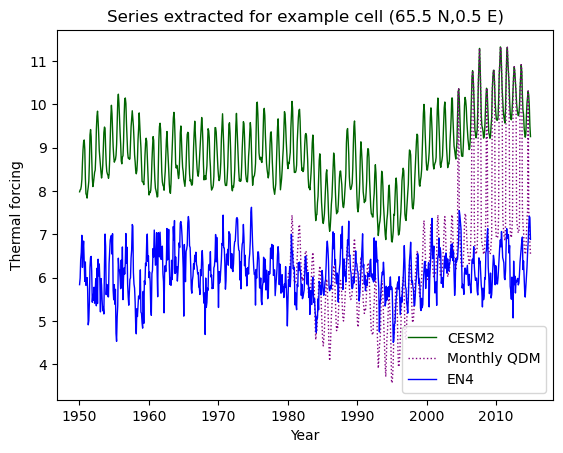

In [18]:
## select a single site to plot
lat_sel = 65.5 ## deg N
lon_sel = 0.5 ## deg E

test_series = test_ds_full.tfdpavg0to500_bathymin100.sel(lat=lat_sel, lon=lon_sel, method='nearest')
qdm_series = qdm_result_3d_longperiod.tfdpavg0to500_bathymin100.sel(lat=lat_sel, lon=lon_sel, method='nearest')
en4_series = tobs_repr_match.sel(lat=lat_sel, lon=lon_sel, method='nearest')

fig, ax = plt.subplots()
ax.plot(test_series.time, test_series.values, 
        color='darkgreen', lw=1.0, label='CESM2')

ax.plot(qdm_series.time, qdm_series.values, 
        color='purple', lw=1.0, ls=':', label='Monthly QDM')


ax.plot(en4_series.time, en4_series.values, 
        color='blue', lw=1.0, label='EN4')

ax.legend(loc='best')
ax.set(xlabel='Year', 
       ylabel='Thermal forcing', 
       title='Series extracted for example cell ({} N,{} E)'.format(lat_sel, lon_sel));


Note 30 Jan: QDM appears to do quite badly when the projection has a trend, such that out-of-sample values show up in the series to be corrected.  Look over this.  Emailed collabs 31 Jan.

---
### Annual QDM
Resample both reanalysis and GCM series to annual resolution.  Save the monthly variability from the GCM as a residual.  Apply QDM correction to the annual series, then add the residual monthly variability back in.

In [19]:
annual_ds = test_ds_full.resample(time='YS').mean()
annual_ds

<xarray.Dataset> Size: 1MB
Dimensions:                    (time: 65, lat: 29, lon: 90)
Coordinates:
  * lat                        (lat) float64 232B 57.5 58.5 59.5 ... 84.5 85.5
  * lon                        (lon) float64 720B 0.5 1.5 2.5 ... 358.5 359.5
    spatial_ref                int64 8B 0
  * time                       (time) datetime64[ns] 520B 1950-01-01 ... 2014...
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 1MB 11.85 ... 1.506

In [20]:
residual_ds = test_ds_full.resample(time='ME').ffill() - annual_ds.resample(time='M').ffill()
residual_ds

/Users/eultee/miniforge3/envs/cmet/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


<xarray.Dataset> Size: 16MB
Dimensions:                    (lat: 29, lon: 90, time: 769)
Coordinates:
  * lat                        (lat) float64 232B 57.5 58.5 59.5 ... 84.5 85.5
  * lon                        (lon) float64 720B 0.5 1.5 2.5 ... 358.5 359.5
  * time                       (time) datetime64[ns] 6kB 1950-01-31 ... 2014-...
    spatial_ref                int64 8B 0
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 16MB -2.055 ... -0.00...

In [21]:
qdm_annual = apply_cmfunc(
        method = "quantile_delta_mapping",
        obs = tobs_repr_match.sel(time=slice('1950','1999')).resample(time='A').mean(),
        simh = annual_ds.sel(time=slice('1950', '1980')).rename({'time':'t_simh'}),
        simp = annual_ds.sel(time=slice('1980', '2014')),
        n_quantiles = 100,
        input_core_dims={"obs": "time", "simh": "t_simh", "simp": "time"},
        kind = "+", # to calculate the relative rather than the absolute change, "*" can be used instead of "+" (this is prefered when adjusting precipitation)
    )

/Users/eultee/miniforge3/envs/cmet/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_55537/14849400.py:29: RuntimeWarning: All-NaN slice encountered
  global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_55537/14849400.py:30: RuntimeWarning: All-NaN slice encountered
  global_min = kwargs.get("global_min", min(np.nanmin(obs), np.nanmin(simh)))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_55537/1020608500.py:145: RuntimeWarning: invalid value encountered in divide
  return cdf / cdf[-1]


/Users/eultee/miniforge3/envs/cmet/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


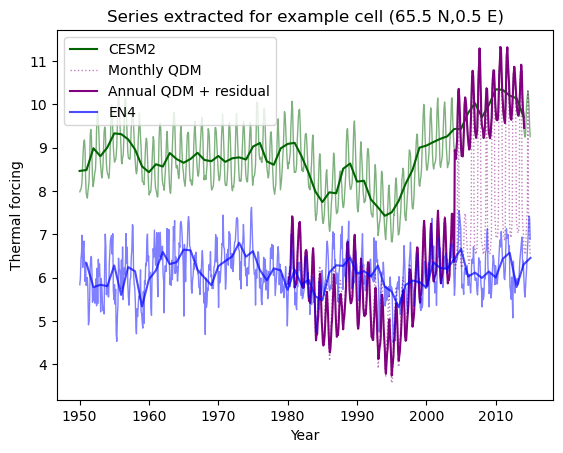

In [22]:
annual_series = annual_ds.tfdpavg0to500_bathymin100.sel(lat=lat_sel, lon=lon_sel, method='nearest')
qdm_annual_series = qdm_annual.tfdpavg0to500_bathymin100.sel(lat=lat_sel, lon=lon_sel, method='nearest')
qdm_plus_resid = qdm_annual_series.resample(time='ME').ffill() + residual_ds.tfdpavg0to500_bathymin100.sel(lat=lat_sel, lon=lon_sel, method='nearest')
en4_annual = en4_series.resample(time='A').mean()

fig, ax = plt.subplots()

ax.plot(test_series.time, test_series.values, 
        color='darkgreen', lw=1.0, alpha=0.5)
ax.plot(annual_series.time, annual_series.values, 
        color='darkgreen', lw=1.5, label='CESM2');

ax.plot(qdm_series.time, qdm_series.values, 
        color='purple', lw=1.0, ls=':', alpha=0.5, label='Monthly QDM');

ax.plot(qdm_plus_resid.time, qdm_plus_resid.values,
        color='purple', lw=1.5, label='Annual QDM + residual');

ax.plot(en4_series.time, en4_series.values, 
        color='blue', lw=1.0, alpha=0.5)
ax.plot(en4_annual.time, en4_annual.values, 
        color='blue', lw=1.5, alpha=0.7, label='EN4');

ax.legend(loc='upper left')
ax.set(xlabel='Year', 
       ylabel='Thermal forcing', 
       title='Series extracted for example cell ({} N,{} E)'.format(lat_sel, lon_sel));
